In [45]:
from census import Census
from us import states
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import my_api_key
import json
from shapely.geometry import Point
matplotlib.style.use('ggplot')
%matplotlib inline

In [57]:
# Read two datasets into dataframes and concatenate into one dataset: crime_df

crime_17_df = pd.read_csv("data/chicago_crime_2017.csv")
crime_18_df = pd.read_csv("data/chicago_crime_2018.csv")
crime_df = pd.concat([crime_17_df, crime_18_df])
# Drop all rows with NAs in Latitude and Longitude
crime_df = crime_df.dropna(subset=["Latitude", "Longitude"])

In [73]:
crime_df.count()

ID                      528529
Case Number             528529
Date                    528529
Block                   528529
IUCR                    528529
Primary Type            528529
Description             528529
Location Description    527088
Arrest                  528529
Domestic                528529
Beat                    528529
District                528528
Ward                    528525
Community Area          528527
FBI Code                528529
X Coordinate            528529
Y Coordinate            528529
Year                    528529
Updated On              528529
Latitude                528529
Longitude               528529
Location                528529
Coordinates             528529
dtype: int64

In [4]:
crime_df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [5]:
type_count_df = crime_df.groupby(["Primary Type", "Year"]).size().to_frame("Count")
type_count_df["Total"] = type_count_df.groupby(level=0)["Count"].transform("sum")
type_count_df = type_count_df.sort_values(['Total', "Year"], ascending=False)
type_count_df.head(20)

Count   Total
Primary Type        Year               
THEFT               2018  65079  129425
                    2017  64346  129425
BATTERY             2018  49782   98996
                    2017  49214   98996
CRIMINAL DAMAGE     2018  27806   56848
                    2017  29042   56848
ASSAULT             2018  20377   39680
                    2017  19303   39680
DECEPTIVE PRACTICE  2018  18725   37753
                    2017  19028   37753
OTHER OFFENSE       2018  17129   34356
                    2017  17227   34356
BURGLARY            2018  11729   24730
                    2017  13001   24730
NARCOTICS           2018  12987   24645
                    2017  11658   24645
ROBBERY             2018   9683   21560
                    2017  11877   21560
MOTOR VEHICLE THEFT 2018   9987   21393
                    2017  11406   21393

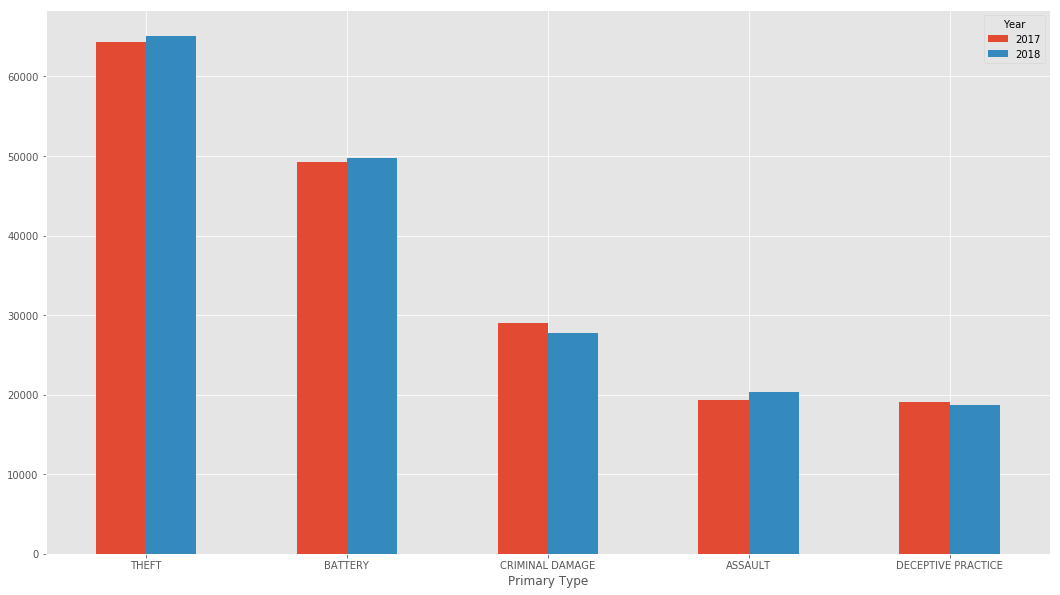

In [6]:
count_ax = type_count_df[:10].Count.unstack().plot.bar(stacked=False, figsize=(18,10), rot=0)
plt.show()

In [7]:
year_df = crime_df.groupby(["Year"]).size().to_frame("Count")
year_df

,Count
Year,
2017,268098
2018,266261


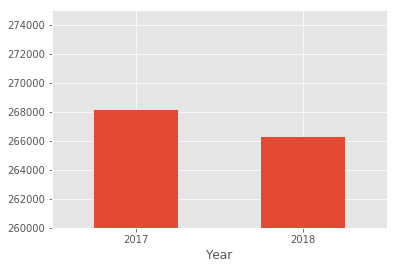

In [8]:
year_ax = year_df.plot(kind="bar", legend=False, rot=0)
year_ax.set_ylim(260000, 275000)
plt.show()

In [39]:
crime_df["Block"].value_counts().count()

30952

In [31]:
crime_df.groupby(["Longitude", "Latitude"]).size().to_frame("Count").sort_values(["Count"], ascending=False)

,,Count
Longitude,Latitude,
-87.627877,41.883500,1006
-87.624097,41.897895,584
-87.905227,41.976290,544
-87.639235,41.868542,502
-87.741529,41.754593,468
-87.709271,41.868181,460
-87.634088,41.742710,427
-87.627845,41.882394,416
-87.627760,41.881718,393


In [15]:
c = Census(my_api_key.MY_API_KEY, year=2017)

In [65]:
#pov_list = c.acs5.state_county_place(("NAME"), '17', '031', Census.ALL)
pov_list = c.acs5.zipcode(('NAME', 'B17001_001E'), Census.ALL)
pov_json = json.dumps(pov_list)
pov_df = pd.read_json(pov_json)
pov_df.head(30)

,B17001_001E,NAME,zip code tabulation area
0,345,ZCTA5 84306,84306
1,414,ZCTA5 84775,84775
2,211,ZCTA5 84762,84762
3,203,ZCTA5 84772,84772
4,224,ZCTA5 84781,84781
5,4353,ZCTA5 84511,84511
6,1649,ZCTA5 84513,84513
7,199,ZCTA5 84516,84516
8,358,ZCTA5 84522,84522
9,9768,ZCTA5 84532,84532


In [44]:
tracts = gpd.read_file("data/census_tract.geojson")
tracts.head()

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,(POLYGON ((-87.62404799998049 41.7302169999839...
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031,(POLYGON ((-87.6860799999848 41.82295600001154...
2,17,8411,34,Census Tract 8411,34,17031841100,,841100,031,(POLYGON ((-87.62934700001182 41.8527970000265...
3,17,8412,31,Census Tract 8412,31,17031841200,,841200,031,(POLYGON ((-87.68813499997718 41.8556909999909...
4,17,8390,32,Census Tract 8390,32,17031839000,,839000,031,(POLYGON ((-87.63312200003458 41.8744880000269...


In [66]:
zip_code = gpd.read_file("data/chicago_zipcode.geojson")
zip_code.head()

,objectid,shape_area,shape_len,zip,geometry
0,33,106052287.488,42720.0444058,60647,(POLYGON ((-87.67762151065281 41.9177578010629...
1,34,127476050.762,48103.7827213,60639,(POLYGON ((-87.72683253163021 41.9226462671259...
2,35,45069038.4783,27288.6096123,60707,(POLYGON ((-87.78500237831095 41.9091478547167...
3,36,70853834.3797,42527.9896789,60622,(POLYGON ((-87.6670686895295 41.88885188496992...
4,37,99039621.2518,47970.1401531,60651,(POLYGON ((-87.70655631674127 41.8955534069940...


In [59]:
crime_df["Coordinates"] = list(zip(crime_df.Longitude, crime_df.Latitude))

In [60]:
crime_df["Coordinates"] = crime_df["Coordinates"].apply(Point)

In [61]:
crime_gdf = gpd.GeoDataFrame(crime_df, geometry='Coordinates')

In [75]:
crime_gdf.head(20)
crime_gdf.count()

ID                      528529
Case Number             528529
Date                    528529
Block                   528529
IUCR                    528529
Primary Type            528529
Description             528529
Location Description    527088
Arrest                  528529
Domestic                528529
Beat                    528529
District                528528
Ward                    528525
Community Area          528527
FBI Code                528529
X Coordinate            528529
Y Coordinate            528529
Year                    528529
Updated On              528529
Latitude                528529
Longitude               528529
Location                528529
Coordinates             528529
dtype: int64

In [76]:
test = gpd.sjoin(crime_gdf, zip_code, how="left", op='intersects')
test.count()

ID                      528529
Case Number             528529
Date                    528529
Block                   528529
IUCR                    528529
Primary Type            528529
Description             528529
Location Description    527088
Arrest                  528529
Domestic                528529
Beat                    528529
District                528528
Ward                    528525
Community Area          528527
FBI Code                528529
X Coordinate            528529
Y Coordinate            528529
Year                    528529
Updated On              528529
Latitude                528529
Longitude               528529
Location                528529
Coordinates             528529
index_right             527076
objectid                527076
shape_area              527076
shape_len               527076
zip                     527076
dtype: int64

In [72]:
test["zip"].value_counts()

60620    24203
60624    23034
60628    21708
60623    21505
60619    20596
60644    18522
60617    17513
60651    16813
60629    16122
60636    15422
60637    15287
60649    14800
60621    14533
60609    13451
60612    13138
60639    12035
60647    11694
60608    10817
60611    10542
60632     9729
60622     9699
60614     9690
60618     9645
60643     8962
60615     8612
60640     8581
60657     8518
60653     8226
60616     8053
60641     7991
60607     7946
60625     7813
60610     7026
60626     7007
60654     6302
60634     5870
60605     5572
60652     5112
60642     5106
60602     5086
60601     4992
60613     4853
60630     4826
60638     4644
60645     4245
60659     4027
60660     3526
60603     3201
60827     2578
60666     2382
60604     2162
60661     2149
60707     1871
60606     1805
60655     1754
60656     1602
60646     1569
60631     1403
60633     1206
Name: zip, dtype: int64

In [74]:
test.count()

ID                      527076
Case Number             527076
Date                    527076
Block                   527076
IUCR                    527076
Primary Type            527076
Description             527076
Location Description    525638
Arrest                  527076
Domestic                527076
Beat                    527076
District                527075
Ward                    527075
Community Area          527074
FBI Code                527076
X Coordinate            527076
Y Coordinate            527076
Year                    527076
Updated On              527076
Latitude                527076
Longitude               527076
Location                527076
Coordinates             527076
index_right             527076
objectid                527076
shape_area              527076
shape_len               527076
zip                     527076
dtype: int64